# Elections et cartes électorales - correction

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Plan

Bidouiller les cartes électorales n'est pas facile mais il n'est pas nécessaire d'être très efficace pour orienter la décision dans un sens ou dans l'autre. L'idée principale consiste à bouger des électeurs d'une circoncription à l'autre pour favoriser les candidats d'un seul parti. Il faut que ces candidats sont élus avec une majorité suffisante tandis que les candidats adversaires doivent l'être avec une grande majorité. C'est une façon de donner plus d'importance aux voix d'un seul parti car elles annulent celles des autres. L'objectif visé est la préparation d'une prochaine élection à partir des résultats de la précédente sans que cela se voit trop. Mais nous pourrions essayer de faire basculer les résultats d'une élection dans un camp ou dans l'autre. Voici un exemple avec trois circonscriptions voisins et de taille équivalente.

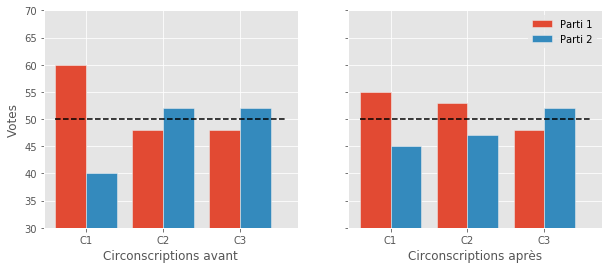

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,4))
ind = [1, 2, 3]
ind2 = [_ + 0.4 for _ in ind]
P1 = (60, 48, 48)
P2 = (40, 52, 52)
ax[0].bar(ind, P1, label="Parti 1", width=0.4)
ax[0].bar(ind2, P2, label="Parti 2", width=0.4)
ax[0].plot([1,4], [50, 50], "--", color="black")
ax[0].set_xlabel('Circonscriptions avant')
plt.setp(ax, xticks=ind2, xticklabels=('C1', 'C2', 'C3'))
P1 = (55, 53, 48)
P2 = (45, 47, 52)
ax[1].bar(ind, P1, label="Parti 1", width=0.4)
ax[1].bar(ind2, P2, label="Parti 2", width=0.4)
ax[1].plot([1,4], [50, 50], "--", color="black")
ax[1].set_xlabel('Circonscriptions après')
ax[0].set_ylabel('Votes')
plt.ylim([30, 70])
plt.legend()

**les moyens**

Nous ne connaissons pas les votes de chaque électeurs mais nous connaissons les résultats agrégés au niveau des bureaux de vote. Nous ne pouvons pas influencer les résultats de l'élection présidentielle car car les votes sont agrégées au niveau du pays : une voix à Perpignan compte autant d'une voix à Charleville. C'est différent pour les élections législatives. Un vote à Charleville n'a qu'un impact dans l'une des [577 circonscriptions](http://www.elections-legislatives.fr/circonscriptions.asp). Que se passe-t-il alors si on fait basculer un bureau de vote d'une circonscription à une autre ?

**la stratégie**

Travailler à plusieurs nécessite de répartir de travailler et d'isoler quelques fonctionnalités qui peuvent être développées en parallèle. Le premier besoin essentielle est celui de la **visualisation** des résultats. Nous allons faire beaucoup d'essais et il faut pouvoir rapidement visualiser le résultat afin d'éviter les erreurs visuellement évidentes. Comme tout projet, il faut un critère numérique qui permette de résumer la qualité d'une solution. Dans notre cas, celui-ci est relié aux nombres de députés élus venant du parti à favoriser. Le second besoin est l'**évaluation** d'une solution. Qu'est ce qui définit une solution ? Ce sont la description des circonscriptions, autrement l'appariement des bureaux de votes aux circonscriptions. Il faut réfléchir à un mécanisme qui nous permette de générer plusieurs solutions, plusieurs appariements. C'est l'étape de **génération** des solutions. C'est sans doute cette dernière partie qui sera la plus complexe car elle doit s'intéresser aux voisinages de bureaux de votes. On peut isoler un traitement spécifique qui consiste à calculer les **voisins** à regarder à partir d'une définition des circonscriptions.

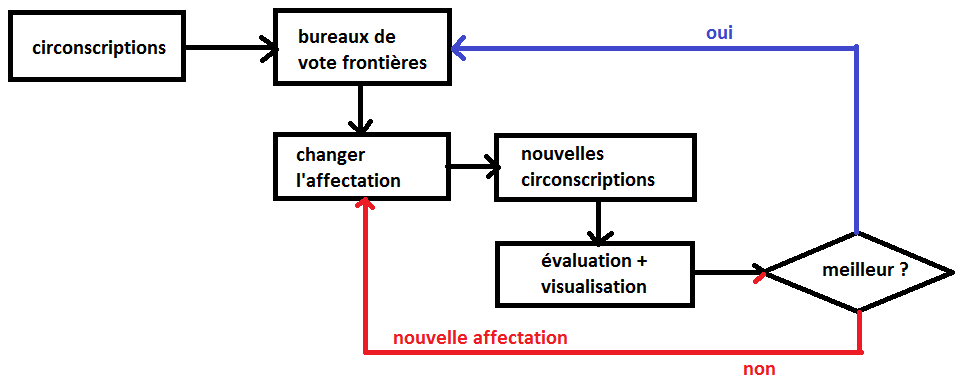

In [ ]:
from pyquickhelper.helpgen import NbImage
NbImage("gerrysol.png")

**travailler en commun**

Si chaque tâche, visualisation, évaluation, génération, peuvent être conçues en parallèle, il faut néanmoins réfléchir aux interfaces : il faut que chaque équipe sache sous quelle forme l'autre équipe va échanger des informations avec elle. Même si les données sont partagées par tout le monde et sont décrites dans des tables, il est préférable de préciser les colonnes importantes dans chacune d'entre elles. Par soucis de simplification, on ne s'intéresse qu'au second tour : la méthode ne s'adresse qu'au parti principaux et on fait l'hypothèse qu'ils sont en majorité présent au second tour.

* *résultat des élections* 

    * code département + code commune + code canton + bureau de vote = **identifiant bureau de vote**
    * **numéro circonscription**
    * inscrits
    * votants
    * exprimés
    * nuance du candidat
    * nombre de voix du candidat
    
* *geo* 

    * **code circonscription**
    * shape
    * **numero**
    
* *bureau_geo* 

    * **numero**
    * longitude
    * latitude
    
En gras, les champs qui serviront à faire des jointures. En second plan, il faut définir une façon commune de décrire les informations dont on a besoin tout au long de la chaîne de traitement :

* solution : un dictionnaire ``{ circonscription : [ liste des bureaux ] } ``
* bureaux fontières et voisins : un dictionnaire ``{ bureau : [ liste des bureaux voisins ] }``

**données manquantes**

La location des bureaux de votes n'est pas disponible pour tous les bureaux de votes. On ne pourra déplacer que ceux qu'on sait localiser.

## Données

On reprend les exemples de code fournis dans le notebook de l'énoncé.

* [Résultat des élections législatives françaises de 2012 au niveau bureau de vote](https://www.data.gouv.fr/fr/datasets/resultat-des-elections-legislatives-francaises-de-2012-au-niveau-bureau-de-vote-nd/)
* [Countours des circonscriptions des législatives](https://www.data.gouv.fr/fr/datasets/countours-des-circonscriptions-des-legislatives-nd/)
* [Localisation des buraux de votes](http://www.xavierdupre.fr/enseignement/complements/bureauxvotegeo.zip)
* [Localisation des villes](https://github.com/sdpython/actuariat_python/raw/master/src/actuariat_python/data/data_elections/villes_geo.zip)

In [ ]:
from actuariat_python.data import elections_legislatives_bureau_vote
tour = elections_legislatives_bureau_vote()
tour["T2"].sort_values(["Code département", "N° de circonscription Lg"]).head(n=2)

,N° tour,Code département,Code de la commune,Nom de la commune,N° de circonscription Lg,N° de canton,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt du candidat,Nom du candidat,Prénom du candidat,Code nuance du candidat,Nombre de voix du candidat
3858,2,01,16,Arbigny,1,26,0001,309,146,144,32,BRETON,Xavier,UMP,87
3859,2,01,16,Arbigny,1,26,0001,309,146,144,33,DEBAT,Jean-François,SOC,57


In [ ]:
from actuariat_python.data import elections_legislatives_circonscription_geo
geo = elections_legislatives_circonscription_geo()
geo.sort_values(["department", "code_circonscription"]).head(n=2)

,code_circonscription,department,numero,communes,kml_shape,simple_form
11,01001,01,1,01053-01072-01106-01150-01177-01184-01195-0124...,<Polygon><outerBoundaryIs><LinearRing><coordin...,False
12,01002,01,2,01008-01047-01099-01202-01213-01224-01366-0138...,<Polygon><outerBoundaryIs><LinearRing><coordin...,True


In [ ]:
from actuariat_python.data import elections_vote_places_geo
bureau_geo = elections_vote_places_geo()
bureau_geo.head(n=2)

,address,city,n,place,zip,full_address,latitude,longitude,geo_address
0,cours verdun,bourg,1,salle des fêtes,1000,cours verdun 01000 bourg,46.206605,5.228364,"Cours de Verdun, Le Peloux, Les Vennes, Bourg-..."
1,cours verdun,bourg,2,salle des fêtes,1000,cours verdun 01000 bourg,46.206605,5.228364,"Cours de Verdun, Le Peloux, Les Vennes, Bourg-..."


## Statistiques

In [ ]:
t2 = tour["T2"]
t2.columns

Index(['N° tour', 'Code département', 'Code de la commune',
       'Nom de la commune', 'N° de circonscription Lg', 'N° de canton',
       'N° de bureau de vote', 'Inscrits', 'Votants', 'Exprimés',
       'N° de dépôt du candidat', 'Nom du candidat', 'Prénom du candidat',
       'Code nuance du candidat', 'Nombre de voix du candidat'],
      dtype='object')

Nous allons ajouter un identifiant pour les bureaux et les circonscriptions afin d'opérer des fusions entre données plus facilement. Comme l'objetif est de changer les bureaux de vote de circonscription, le code de la circonscription ne peut pas être utilisé pour identifier un bureau de vote. Nous allons vérifier que cette hypothèse tient la route.

In [ ]:
cols = ["Code département", "Code de la commune", "N° de canton", "N° de bureau de vote"]
def code_bureau(dd, cc, aa, bb):
    bb = bb if isinstance(bb, str) else ("%03d" % bb)
    if len(bb) > 3: bb = bb[-3:]
    cc = cc if isinstance(cc, str) else ("%03d" % cc)
    aa = aa if isinstance(aa, str) else ("%02d" % aa)
    dd = dd if isinstance(dd, str) else ("%02d" % dd)
    # on ajoute un "#" à la fin pour éviter que pandas converisse la colonne numérique
    # et supprime les 0 devant l'identifiant
    return dd + cc + aa + bb + "#"
t2["idbureau"] = t2.apply(lambda row: code_bureau(*[row[c] for c in cols]), axis=1)
t2.head(n=2)

,N° tour,Code département,Code de la commune,Nom de la commune,N° de circonscription Lg,N° de canton,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt du candidat,Nom du candidat,Prénom du candidat,Code nuance du candidat,Nombre de voix du candidat,idbureau
0,2,ZA,101,Les Abymes,1,1,0001,477,252,236,9,JALTON,Eric,SOC,182,ZA10101001#
1,2,ZA,101,Les Abymes,1,1,0001,477,252,236,17,DURIMEL,Harry,VEC,54,ZA10101001#


In [ ]:
t2["idcirc"] = t2.apply(lambda row: str(row["Code département"]) + "%03d" % row["N° de circonscription Lg"] + "#", axis=1)
t2.head(n=2)

,N° tour,Code département,Code de la commune,Nom de la commune,N° de circonscription Lg,N° de canton,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt du candidat,Nom du candidat,Prénom du candidat,Code nuance du candidat,Nombre de voix du candidat,idbureau,idcirc
0,2,ZA,101,Les Abymes,1,1,0001,477,252,236,9,JALTON,Eric,SOC,182,ZA10101001#,ZA001#
1,2,ZA,101,Les Abymes,1,1,0001,477,252,236,17,DURIMEL,Harry,VEC,54,ZA10101001#,ZA001#


In [ ]:
len(set(t2["idcirc"]))

541

541 < 577 est inférieur au nombre de députés. Cela signifie que 577 - 541 députés ont été élus au premier tour. Il faut aller récupérer les données du premier tour pour ces circonscriptions.

In [ ]:
t2circ = set(t2["idcirc"])
t1 = tour["T1"]
t1["idcirc"] = t1.apply(lambda row: str(row["Code département"]) + "%03d" % row["N° de circonscription Lg"] + "#", axis=1)
t1["idbureau"] = t1.apply(lambda row: code_bureau(*[row[c] for c in cols]), axis=1)
t1["elu"] = t1["idcirc"].apply(lambda r: r not in t2circ)
t1nott2 = t1[t1["elu"]].copy()
t1nott2.head(n=2)

,N° tour,Code département,Code de la commune,Nom de la commune,N° de circonscription Lg,N° de canton,N° de bureau de vote,Inscrits,Votants,Exprimés,N° de dépôt du candidat,Nom du candidat,Prénom du candidat,Code nuance du candidat,Nombre de voix du candidat,idcirc,idbureau,elu
688,1,ZA,104,Baillif,4,36,0001,813,386,357,3,GUILLE,Marc,FN,4,ZA004#,ZA10436001#,True
689,1,ZA,104,Baillif,4,36,0001,813,386,357,18,MOLINIE,Louis,DVD,6,ZA004#,ZA10436001#,True


In [ ]:
len(set(t1nott2["idcirc"])) + 541

577

Il ne reste plus qu'à les ajouter aux données du second tour.

In [ ]:
import pandas
t1t2 = pandas.concat([t1nott2, t2], axis=0)

In [ ]:
statbu = t1t2[["Code département", "idcirc", "idbureau", 
               "Inscrits"]].groupby(["Code département", "idcirc", "idbureau"], as_index=False).max()
statbu.head()

,Code département,idcirc,idbureau,Inscrits
0,01,01001#,0101626001#,309
1,01,01001#,0102421001#,746
2,01,01001#,0102421002#,1311
3,01,01001#,0102911001#,411
4,01,01001#,0103811001#,558


In [ ]:
statbu.sort_values("Inscrits", ascending=False).head(n=5)

,Code département,idcirc,idbureau,Inscrits
67921,ZZ,ZZ001#,ZZ00101001#,156645
67928,ZZ,ZZ008#,ZZ00808001#,109389
67926,ZZ,ZZ006#,ZZ00606001#,106689
67929,ZZ,ZZ009#,ZZ00909001#,97068
67924,ZZ,ZZ004#,ZZ00404001#,96964


In [ ]:
"nombre de bureaux de vote", statbu.shape[0]

('nombre de bureaux de vote', 67932)

A priori, le département ``ZZ`` est une erreur. On vérifie.

In [ ]:
t1t2[t1t2["Code département"] == "ZZ"].head(n=2)

,Code de la commune,Code département,Code nuance du candidat,Exprimés,Inscrits,Nom de la commune,Nom du candidat,Nombre de voix du candidat,N° de bureau de vote,N° de canton,N° de circonscription Lg,N° de dépôt du candidat,N° tour,Prénom du candidat,Votants,elu,idbureau,idcirc
3789,1,ZZ,UMP,29223,156645,Amérique du Nord,LEFEBVRE,13441,0001,1,1,117,2,Frédéric,29869,NaN,ZZ00101001#,ZZ001#
3790,1,ZZ,SOC,29223,156645,Amérique du Nord,NARASSIGUIN,15782,0001,1,1,143,2,Corinne,29869,NaN,ZZ00101001#,ZZ001#


Ce bureau de vote n'est pas en France. Il est bien plus volumineux que les autres et nous ne pourrons pas le rapprocher géographiquement des autres. On n'en tiendra plus compte. On enlève également le bureau de vote ``ZW``.

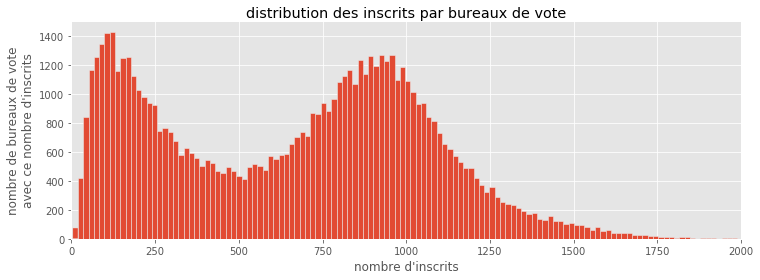

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
statbu[(statbu["Code département"] != "ZZ") & (statbu["Code département"] != "ZW")].hist( \
        bins=200, ax=ax)
ax.set_xlim(0, 2000)
ax.set_xlabel("nombre d'inscrits")
ax.set_ylabel("nombre de bureaux de vote\navec ce nombre d'inscrits")
ax.set_title("distribution des inscrits par bureaux de vote")

In [ ]:
nbbur = statbu[["idcirc","idbureau"]].groupby("idcirc").count()
nbbur.columns=["nombre de bureaux de vote"]
nbbur.head()

,nombre de bureaux de vote
idcirc,
01001#,117
01002#,98
01003#,106
01004#,113
01005#,145


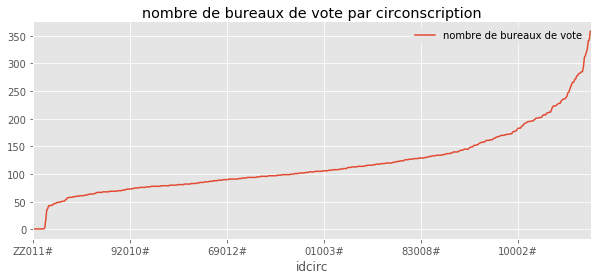

In [ ]:
ax = nbbur[nbbur[nbbur.columns[0]] > 0].sort_values(nbbur.columns[0]).plot(figsize=(10,4))
ax.set_title("nombre de bureaux de vote par circonscription")

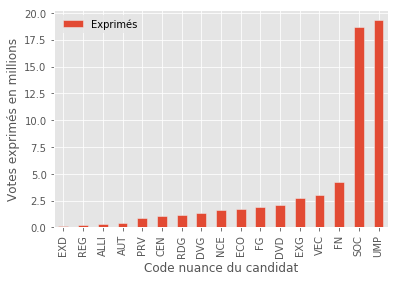

In [ ]:
t1t2noz = t1t2[t1t2["Code département"].apply(lambda r: not r.startswith("Z"))]
elu = t1t2noz[["Code nuance du candidat", "Exprimés"]].groupby("Code nuance du candidat").sum()
ax = (elu.sort_values("Exprimés")/1000000).plot(kind="bar")
ax.set_ylabel("Votes exprimés en millions")

## Identifiants

Nous aurons besoin de croiser les données provenant de plusieurs bases en fonction des circonscriptions et des bureaux de votes. Il convient de déterminer ce qui identifient de façon unique un bureau de vote et une circonscription. Il faut se rappeler des conventions choisies :

* identifiant cironscription : **DDCCC#**, ``D`` pour code département, ``C`` pour code circonscription
* identifiant bureau de vote : **DDMMAABBB#**, ``D`` pour code département, ``M`` pour code commune, ``A`` pour code canton, ``B`` pour code bureau

Le caractère ``#`` sert à éviter la conversion automatique d'une colonne au format numérique par pandas.

In [ ]:
t1t2.head(n=2)

,Code de la commune,Code département,Code nuance du candidat,Exprimés,Inscrits,Nom de la commune,Nom du candidat,Nombre de voix du candidat,N° de bureau de vote,N° de canton,N° de circonscription Lg,N° de dépôt du candidat,N° tour,Prénom du candidat,Votants,elu,idbureau,idcirc
688,104,ZA,FN,357,813,Baillif,GUILLE,4,0001,36,4,3,1,Marc,386,True,ZA10436001#,ZA004#
689,104,ZA,DVD,357,813,Baillif,MOLINIE,6,0001,36,4,18,1,Louis,386,True,ZA10436001#,ZA004#


In [ ]:
len(set(t1t2["idcirc"]))

577

Le nombre de cirsconscription est le nombre attendu. On vérifie que les circonscriptions ne s'étendant pas sur plusieurs départements. Cela signifie que nous pouvons optimiser les répartitions des bureaux par département de façon indépendantes.

In [ ]:
t1t2.groupby(["idcirc", "Code département"], as_index=False).count().shape

(577, 18)

La ligne suivante montre qu'une circonscription englobe plusieurs cantons.

In [ ]:
t1t2.groupby(["idcirc", "N° de canton"], as_index=False).count().shape

(4171, 18)

Combien y a-t-il de bureaux de vote ?

In [ ]:
len(set(t1t2["idbureau"]))

67932

On vérifie que nous n'avons pas plusieurs le même nom de bureaux pour une même circonscription auquel cas cela voudrait dire que l'identifiant choisi n'est pas le bon.

In [ ]:
t1t2.groupby(["idcirc", "idbureau"], as_index=False).count().shape

(67932, 18)

Tout va bien !

## Evaluation d'une solution

Dans la suite, on se sert des deux colonnes ``idbureau`` et ``idcirc`` comme identifiant de bureaux et circonscription et on s'intéresse à une association *circonscription - bureau* quelconque.

In [ ]:
import numpy

def agg_circonscription(data_vote, solution=None, col_circ="idcirc", 
                        col_place="idbureau", col_vote="Nombre de voix du candidat",
                        col_nuance="Code nuance du candidat"):
    """
    Calcul la nuance gagnante dans chaque circonscription.
    
    @param     data_vote    dataframe de type
    @param     solution     dictionnaire ``{ circonscription : liste de bureaux }``, 
                            si None considère la solution officielle
    @param     col_circ     colonne contenant la circonscription (si solution = None)
    @param     col_place    colonne contenant l'identifiant du bureaux de votes
    @param     col_vote     colonne contenant les votes
    @param     col_nuance   colonne contenant le parti ou la nuance
    @return                 matrice de résultats, une ligne par circoncription, une colonne par nuance/parti
    """
    if solution is None:
        # on reprend l'association circoncscription - bureau de la dernière élection
        agg = data_vote[[col_circ, col_nuance, col_vote]].groupby([col_circ, col_nuance], as_index=False).sum()
    else:
        # on construit la nouvelle association
        rev = {}
        for k, v in solution.items():
            for place in v:
                if place in rev:
                    raise ValueError("Un bureaux est associé à deux circonscriptions : {0}".format([rev[place], k]))
                rev[place] = k
        keep = data_vote[[col_place, col_vote, col_nuance]].copy()
        keep[col_circ] = keep[col_place].apply(lambda r: rev[r])
        agg = keep[[col_circ, col_nuance, col_vote]].groupby([col_circ, col_nuance], as_index=False).sum()
        
    # les données sont maintenant agrégées par circonscription, il faut déterminer le gagnant
    piv = agg.pivot(col_circ, col_nuance, col_vote)
    gagnant = []
    votes = []
    sums = []
    
    for row in piv.values:
        mx = max((r, i) for i, r in enumerate(row) if not numpy.isnan(r))
        gagnant.append(piv.columns[mx[1]])
        votes.append(mx[0])
        sums.append(sum(r for r in row if not numpy.isnan(r)))
        
    piv["winner"] = gagnant
    piv["nbwinner"] = votes
    piv["total"] = sums
    return piv
     
score = agg_circonscription(t1t2noz)
score.head()

Code nuance du candidat,ALLI,AUT,CEN,DVD,DVG,ECO,EXD,EXG,FG,FN,NCE,PRV,RDG,REG,SOC,UMP,VEC,winner,nbwinner,total
idcirc,,,,,,,,,,,,,,,,,,,,
01001#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22743.0,24233.0,NaN,UMP,24233.0,46976.0
01002#,NaN,NaN,NaN,NaN,19529.0,NaN,NaN,NaN,NaN,8530.0,NaN,NaN,NaN,NaN,NaN,22327.0,NaN,UMP,22327.0,50386.0
01003#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15653.0,19266.0,NaN,UMP,19266.0,34919.0
01004#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19780.0,NaN,NaN,26175.0,NaN,UMP,26175.0,45955.0
01005#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17012.0,22008.0,NaN,UMP,22008.0,39020.0


In [ ]:
score.shape

(539, 20)

In [ ]:
len(set(t1t2noz["idcirc"]))

539

In [ ]:
len(set(t1t2["idcirc"]))

577

Le processus ne s'appliquera qu'aux circonscriptions de la métropole, soit 565. Le résultat d'une nouvelle répartition peut être calculée comme ceci :

In [ ]:
count = score[["winner", "nbwinner"]].groupby(["winner"]).count()
count.sort_values("nbwinner", ascending=False)

Code nuance du candidat,nbwinner
winner,
SOC,263
UMP,190
DVG,16
VEC,16
NCE,12
RDG,11
FG,10
DVD,9
PRV,6


## Visualisation d'une solution

### Première carte : circonscriptions actuelles

On reprend la même signature que la fonction précédente avec le dataframe ``geo`` qui contient la définition des circonscriptions. On commence par créer une fonction qui extrait les contours qui sont disponibles sous formes de chaînes de caractères. Le résultat est inspiré de ce [notebook](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td1a_cenonce_session_12.html#cartographie).

In [ ]:
def process_boundary(bound_string):
    ext = bound_string.split("<coordinates>")[-1].split("</coordinates>")[0]
    spl = ext.split(" ")
    return [(float(ll[0]), float(ll[1])) for ll in [_.split(",") for _ in spl]]

s = """
    <Polygon><outerBoundaryIs><LinearRing><coordinates>5.294455999999968,46.193934 5.279780999999957,46.201967</coordinates></LinearRing></outerBoundaryIs></Polygon>
    """
r = process_boundary(s)
r

[(5.294455999999968, 46.193934), (5.279780999999957, 46.201967)]

Certaines circonscriptions n'ont pas de contours.

In [ ]:
geo[geo.code_circonscription=="98702"]

,code_circonscription,department,numero,communes,kml_shape,simple_form
575,98702,987,2,NaN,NaN,True


La fonction suivante projette les circonscription existantes car on ne sait pas encore construire le contour d'une circonscription construite à partir d'une solution.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A827B4DD8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000023A82817470>], dtype=object)

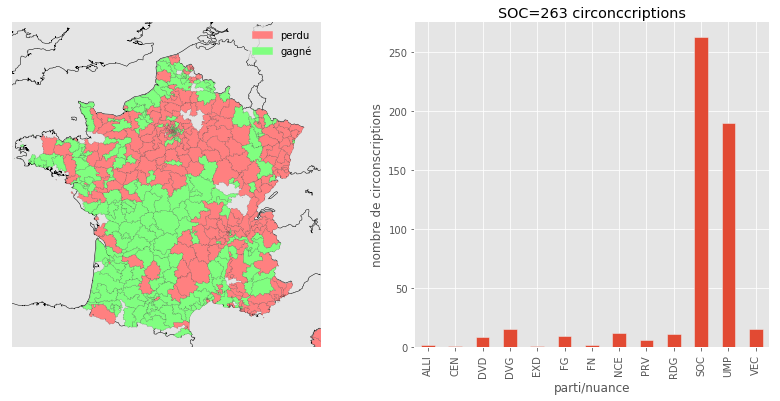

In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.patches as mpatches

def agg_circonscription_viz(thewinner, geo, data_vote,
                 col_circ="idcirc", col_place="idbureau", col_vote="Nombre de voix du candidat",
                 col_nuance="Code nuance du candidat", axes=None, figsize=(14,6), **kwargs):
    """
    Visualise la nuance gagnante dans chaque circonscription.
    
    @param     thewinner    parti qu'on souhaite influencer
    @param     geo          shapes pour chaque circonscription
    @param     axes         None ou deux systèmes d'axes
    @param     figsize      dimension du graphiques
    @param     kwargs       options additionnelles
    
    @param     data_vote    dataframe de type
    @param     col_circ     colonne contenant la circonscription (si solution = None)
    @param     col_place    colonne contenant l'identifiant du bureaux de votes
    @param     col_vote     colonne contenant les votes
    @param     col_nuance   colonne contenant le parti ou la nuance
    @return                 matrice de resultat, une ligne par circoncription, une colonne par nuance/parti
    """
    # on transforme les dataframes en dictionnaires
    score = agg_circonscription(data_vote, col_circ=col_circ, col_place=col_place,
                                col_vote=col_vote, col_nuance=col_nuance)
    winner = score[["winner"]].to_dict("index")
    shapes = geo.set_index("code_circonscription")[["kml_shape"]].to_dict("index")
    
    if axes is None:
        # on créé des axes si non définis
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
    # on dessine la distribution des circonscriptions
    count = score[["winner", "nbwinner"]].groupby(["winner"]).count()
    count.sort_values("nbwinner", ascending=False)
    count.plot(ax=axes[1], kind="bar", legend=False)
    axes[1].set_xlabel("parti/nuance")
    axes[1].set_ylabel("nombre de circonscriptions")

    # on calcule le nombre de places le parti considéré
    count = count.reset_index(drop=False)
    count["iswin"] = count["winner"] == thewinner
    ratio = count[["nbwinner", "iswin"]].groupby("iswin").sum().sort_index()
    nbcirc = ratio.ix[1,0]
    axes[1].set_title("{0}={1} circonccriptions".format(thewinner, nbcirc))
    
    x1, x2 = -5.0, 9.
    y1, y2 = 42., 52.
    m = Basemap(resolution='i',projection='merc', llcrnrlat=y1, urcrnrlat=y2, 
                llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2, ax=axes[0])
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    for circ, vals in shapes.items():
        if circ.startswith("Z"):
            # outside
            continue
        if not circ.endswith("#"):
            # nous avons ajouté un dièse
            circ += "#"
        sh = vals["kml_shape"]
        if isinstance(sh, float):
            # NaN
            continue
        geo_points = process_boundary(sh)
        lons = [_[0] for _ in geo_points]
        lats = [_[1] for _ in geo_points]
        data = numpy.array(m(lons, lats)).T
        segs = [data,]
        lines = LineCollection(segs,antialiaseds=(1,))
        # pour changer les couleurs c'est ici, il faudra utiliser le champ records
        # pour les changer en fonction du nom du départements
        if circ in winner:
            win = winner[circ]["winner"]
            color = (0.5, 1.0, 0.5) if win == thewinner else (1.0, 0.5, 0.5)
        else:
            color = "black"            
        lines.set_facecolors(color)
        lines.set_edgecolors('k')
        lines.set_linewidth(0.1)
        axes[0].add_collection(lines)  

    red_patch = mpatches.Patch(color=(1.0, 0.5, 0.5), label='perdu')
    green_patch = mpatches.Patch(color=(0.5, 1.0, 0.5), label='gagné')
    axes[0].legend(handles=[red_patch, green_patch])        

    return axes
    
agg_circonscription_viz("SOC", geo, t1t2noz)

Certaines parties du territoires manquent. Les contours manquent ou les résultats manquent pour une certaine circonscription. La cohérence des données devraient être vérifiées car celles-ci viennent de sources différentes.

### Seconde carte : nouvelles circonscriptions

Si on change les circonscriptions, les contours des anciennes circonscriptions ne sont plus valables ! Si on ne dispose que de la position des bureaux de vote, il faut reconstruire le contour de chaque circonscription en fonction de la position des bureaux de vote. La méthode : construire un [graphe de Voronoï](https://fr.wikipedia.org/wiki/Diagramme_de_Vorono%C3%AF)
et ne garder que les frontières entre bureaux de circonscriptions différentes. Si on dispose de contour pour chaqeu bureau de vote, l'autre option consiste à fusionner ces contours en éliminant la surface commune. C'est ce que fait la fonction [cascade_union](http://toblerity.org/shapely/manual.html#shapely.ops.cascaded_union) du module [shapely](https://pypi.python.org/pypi/Shapely). 

Le problème principal devient l'association de la location des bureaux de vote avec les résultats des votes. Tout d'abord nous avons besoin de vérifier que nous avons suffisamment de bureaux de vote localisé dans la base *bureau_geo* et on s'aperçoit que c'est largement insuffisant.

In [ ]:
cols = ["city", "zip", "n"]
bureau_geo["idbureaugeo"] = bureau_geo.apply(lambda row: "-".join(str(row[_]) for _ in cols), axis=1)

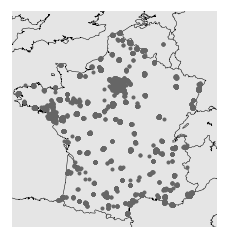

In [ ]:
fig, ax = plt.subplots()

x1, x2 = -5.0, 9.
y1, y2 = 42., 52.
m = Basemap(resolution='i',projection='merc', llcrnrlat=y1, urcrnrlat=y2, 
            llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2, ax=ax)
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)

lons = bureau_geo["longitude"]
lats = bureau_geo["latitude"]
data = [m(x, y) for x,y in zip(lons, lats)]
xs = [_[0] for _ in data]
ys = [_[1] for _ in data]
ax.plot(xs, ys, ".", color=(0.4, 0.4, 0.4))

### Autres sources pour les bureaux de votes

La faible densité des bureaux de votes oblige à changer de jeu de données et d'utiliser celui de [cartelec](http://www.cartelec.net/?page_id=3609) utilisé pour l'année 2007. Il devrait en grande majorité valable pour l'année 2012 ce que nous ne vérifierons pas ici.

In [ ]:
from pyensae.datasource import download_data
shp_vote = download_data("base_cartelec_2007_2010.zip")
import shapefile
r = shapefile.Reader("fond0710.shp")
rshp = r
shapes = r.shapes()
records = r.records()

In [ ]:
{k[0]:v for k,v in zip(r.fields[1:], records[0])}, shapes[0].points[:5]

({'BUREAU': '01001',
  'CANTON': 'CHATILLON-SUR-CHALARONNE',
  'CIRCO': '04',
  'CODE': '01001',
  'CODEARRT': '012',
  'CODECANT': '10',
  'CODEDEP': '01',
  'CODEREG': '82',
  'NOM': b"L'Abergement-Cl\xe9menciat"},
 [[846774.7025280485, 6563840.655779875],
  [847430.4726776106, 6566444.631470905],
  [848975.0615885032, 6566530.102978201],
  [849532.5253064571, 6565971.4588501565],
  [848969.0813380895, 6564398.911644492]])

In [ ]:
shapes[0].__dict__

{'bbox': [846774.7025280485, 6559575.068823495, 850941.7401535356, 6566530.102978201],
 'parts': [0],
 'points': [[846774.7025280485, 6563840.655779875],
  [847430.4726776106, 6566444.631470905],
  [848975.0615885032, 6566530.102978201],
  [849532.5253064571, 6565971.4588501565],
  [848969.0813380895, 6564398.911644492],
  [850941.7401535356, 6563209.5425065085],
  [849896.4212796891, 6562719.844144765],
  [849632.2745031306, 6561522.415193593],
  [849891.0276243397, 6560738.406460746],
  [848732.0257644501, 6559575.068823495],
  [848585.9032087281, 6560169.582690463],
  [847664.0345600601, 6560616.395794825],
  [847793.2580021, 6562243.125831007],
  [846774.7025280485, 6563840.655779875]],
 'shapeType': 5}

Les coordonnées ne sont pas des longitude, latitude. Il faut les convertir.

### Conversion des coordoonnées et identifiant de bureau

Voir ce [notebook](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td1a_cenonce_session_12.html#cartographie). La fonction qui suit est assez longue exécutée un grand nombre de fois. Il faudrait l'accélérer avec [numba](http://numba.pydata.org/) ou [cython](http://cython.org/). Dans notre cas, le traitement n'est pas encore trop long et n'est exécuté qu'une fois.

In [ ]:
import math
def lambert932WGPS(lambertE, lambertN):
    class constantes:
        GRS80E = 0.081819191042816
        LONG_0 = 3
        XS = 700000
        YS = 12655612.0499
        n = 0.7256077650532670
        C = 11754255.4261
    delX = lambertE - constantes.XS
    delY = lambertN - constantes.YS
    gamma = math.atan(-delX / delY)
    R = math.sqrt(delX * delX + delY * delY)
    latiso = math.log(constantes.C / R) / constantes.n
    sinPhiit0 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * math.sin(1)))
    sinPhiit1 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit0))
    sinPhiit2 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit1))
    sinPhiit3 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit2))
    sinPhiit4 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit3))
    sinPhiit5 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit4))
    sinPhiit6 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit5))
    longRad = math.asin(sinPhiit6)
    latRad = gamma / constantes.n + constantes.LONG_0 / 180 * math.pi
    longitude = latRad / math.pi * 180
    latitude = longRad / math.pi * 180
    return longitude, latitude
lambert932WGPS(99217.1, 6049646.300000001), lambert932WGPS(1242417.2, 7110480.100000001)

((-4.1615802638173065, 41.303505287589545),
 (10.699505053975292, 50.85243395553585))

In [ ]:
for shape in shapes:
    x1, y1 = lambert932WGPS(shape.bbox[0], shape.bbox[1])
    x2, y2 = lambert932WGPS(shape.bbox[2], shape.bbox[3])
    shape.bbox = [x1, y1, x2, y2]
    shape.points = [lambert932WGPS(x,y) for x,y in shape.points]

On vérifie que nous disposons de beaucoup plus de bureaux de vote localisés.

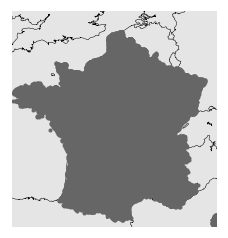

In [ ]:
fig, ax = plt.subplots()

x1, x2 = -5.0, 9.
y1, y2 = 42., 52.
m = Basemap(resolution='i',projection='merc', llcrnrlat=y1, urcrnrlat=y2, 
            llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2, ax=ax)
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)

lons = []
lats = []
for shape in shapes:
    x1, y1, x2, y2 = shape.bbox
    x = (x1+x2) / 2
    y = (y1+y2) / 2
    lons.append(x)
    lats.append(y)
data = [m(x, y) for x,y in zip(lons, lats)]
xs = [_[0] for _ in data]
ys = [_[1] for _ in data]
ax.plot(xs, ys, ".", color=(0.4, 0.4, 0.4))

La France est recouvert de gris. La densité des bureaux de votes est plus conforme à celle attendue. La conversion des coordonnées a fonctionné et les données seront exploitables.

In [ ]:
len(shapes), len(set(t1t2noz.idbureau))

(50578, 65717)

C'est quand même moins que les 67920 bureaux de vote enregistrés dans la table des élections ! Il y a 17000 bureaux de votes que nous ne pouvons pas localiser. On essaye un bureau au hasard pour deviner le sens des informations fournies dans les *records* :

In [ ]:
{k[0]:v for k,v in zip(r.fields[1:], records[11000])}

{'BUREAU': '25038',
 'CANTON': 'ROUGEMONT',
 'CIRCO': '03',
 'CODE': '25038',
 'CODEARRT': '251',
 'CODECANT': '23',
 'CODEDEP': '25',
 'CODEREG': '43',
 'NOM': 'Avilley'}

In [ ]:
t1t2[t1t2["Nom de la commune"] == "Avilley"]

,Code de la commune,Code département,Code nuance du candidat,Exprimés,Inscrits,Nom de la commune,Nom du candidat,Nombre de voix du candidat,N° de bureau de vote,N° de canton,N° de circonscription Lg,N° de dépôt du candidat,N° tour,Prénom du candidat,Votants,elu,idbureau,idcirc
29979,38,25,UMP,96,153,Avilley,BONNOT,60,0001,23,3,47,2,Marcel,98,NaN,2503823001#,25003#
29980,38,25,SOC,96,153,Avilley,MARTHEY,36,0001,23,3,50,2,Arnaud,98,NaN,2503823001#,25003#


Où est le code du bureau ?

In [ ]:
t1t2[t1t2["Nom de la commune"] == "Nouzonville"]

,Code de la commune,Code département,Code nuance du candidat,Exprimés,Inscrits,Nom de la commune,Nom du candidat,Nombre de voix du candidat,N° de bureau de vote,N° de canton,N° de circonscription Lg,N° de dépôt du candidat,N° tour,Prénom du candidat,Votants,elu,idbureau,idcirc
12229,328,08,SOC,755,1707,Nouzonville,LEONARD,486,0001,34,2,18,2,Christophe,782,NaN,0832834001#,08002#
12230,328,08,UMP,755,1707,Nouzonville,RAVIGNON,269,0001,34,2,27,2,Boris,782,NaN,0832834001#,08002#
12231,328,08,SOC,711,1565,Nouzonville,LEONARD,481,0002,34,2,18,2,Christophe,732,NaN,0832834002#,08002#
12232,328,08,UMP,711,1565,Nouzonville,RAVIGNON,230,0002,34,2,27,2,Boris,732,NaN,0832834002#,08002#
12233,328,08,SOC,571,1149,Nouzonville,LEONARD,357,0003,34,2,18,2,Christophe,590,NaN,0832834003#,08002#
12234,328,08,UMP,571,1149,Nouzonville,RAVIGNON,214,0003,34,2,27,2,Boris,590,NaN,0832834003#,08002#


In [ ]:
[ {k[0]:v for k,v in zip(r.fields[1:], rec)} for rec in records if "Nouzonville" in rec]

[{'BUREAU': '08328',
  'CANTON': 'NOUZONVILLE',
  'CIRCO': '02',
  'CODE': '08328',
  'CODEARRT': '081',
  'CODECANT': '34',
  'CODEDEP': '08',
  'CODEREG': '21',
  'NOM': 'Nouzonville'}]

On regarde à Paris.

In [ ]:
[ {k[0]:v for k,v in zip(r.fields[1:], rec)} for rec in records if "Paris-10" in rec][0:2]

[{'BUREAU': '75110_1001',
  'CANTON': 'Paris-10',
  'CIRCO': '05',
  'CODE': '75110',
  'CODEARRT': '751',
  'CODECANT': '24',
  'CODEDEP': '75',
  'CODEREG': '11',
  'NOM': 'Paris 10e  arrondiss'},
 {'BUREAU': '75110_1002',
  'CANTON': 'Paris-10',
  'CIRCO': '05',
  'CODE': '75110',
  'CODEARRT': '751',
  'CODECANT': '24',
  'CODEDEP': '75',
  'CODEREG': '11',
  'NOM': 'Paris 10e  arrondiss'}]

Cela signifie que les bureaux de vote sont regroupées sur les petites villes et pas sur les grandes. Combien avons nous de bureaux de vote uniques et localisés ?

In [ ]:
len([ _ for _ in [ {k[0]:v for k,v in zip(r.fields[1:], rec)} for rec in records] if "_" in _["BUREAU"]])

15837

On peut maintenant reconstruire un identifiant de bureau, complet quand le bureau de vote est présent, incomplet quand il ne l'est pas.

In [ ]:
def shape_idbureau(rec):
    # département + commune + canton + bureau
    if "_" in rec["BUREAU"]:
        bb = "0" + rec["BUREAU"].split("_")[-1][-2:]
    else:
        bb = "***"
    return rec["CODEDEP"] + rec["CODE"][-3:] + rec["CODECANT"] + bb + "#"

shape_idbureau({k[0]:v for k,v in zip(r.fields[1:], records[11000])})

'2503823***#'

### Implications sur la méthode

En résumé, nous avons :

* 67920 bureaux de vote en métropole
* 50578 lieux distincts
* 15837 bureaux de vote clairement identifiés et localisés
* ~35000 lieux qui correspondent au regroupement de bureaux de vote

Pour poursuivre, il va falloir agréger les résultats pour les bureaux de vote qui ont été regroupés dans la base qui fournit leur coordonnées ou tout simplement donner à ces bureaux de vote un identifiant unique. La seconde option, même si elle impose de conserver plus de données à l'avantage d'être plus simple et donc de générer moins d'erreur. 

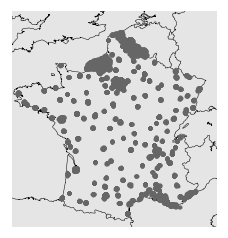

In [ ]:
fig, ax = plt.subplots()

x1, x2 = -5.0, 9.
y1, y2 = 42., 52.
m = Basemap(resolution='i',projection='merc', llcrnrlat=y1, urcrnrlat=y2, 
            llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2, ax=ax)
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)

lons = []
lats = []
for rec, shape in zip(records, shapes):
    d = {k[0]:v for k,v in zip(r.fields[1:], rec)}
    if "_" not in d["BUREAU"]:
        # bureau de vote pas unique
        continue
    x1, y1, x2, y2 = shape.bbox
    x = (x1+x2) / 2
    y = (y1+y2) / 2
    lons.append(x)
    lats.append(y)
data = [m(x, y) for x,y in zip(lons, lats)]
xs = [_[0] for _ in data]
ys = [_[1] for _ in data]
ax.plot(xs, ys, ".", color=(0.4, 0.4, 0.4))

Clairement les grandes et moyennes villes.

In [ ]:
t1t2noz[list(_ for _ in t1t2noz.columns if "Code" in _ or "id" in _ or "N°" in _)].head(n=2)

,Code de la commune,Code département,Code nuance du candidat,Nom du candidat,Nombre de voix du candidat,N° de bureau de vote,N° de canton,N° de circonscription Lg,N° de dépôt du candidat,N° tour,Prénom du candidat,idbureau,idcirc,idbureau2,idb=,idbgeo
47442,4,06,EXG,PETARD,0,0101,1,7,8,1,Christian,0600401101#,06007#,0600401***#,False,True
47443,4,06,FN,VIOT,33,0101,1,7,24,1,Mathilde,0600401101#,06007#,0600401***#,False,True


On choisit maintenant de remplacer les valeurs de la colonne ``idbureau``, si le code ``0600401101#`` n'a pas de localisation connue, cela signifie qu'il est probablement agrégé avec d'autres bureaux de vote. On le remplace par ``0600401***#``. Nous verrons cela plus bas.

### Fusionner les shapefiles

C'est maintenant qu'on va utiliser la fonction [cascade_union](http://toblerity.org/shapely/manual.html#shapely.ops.cascaded_union) du module [shapely](https://pypi.python.org/pypi/Shapely).
On extrait un sous-ensemble de bureaux de vote pour tester la fontion.

In [ ]:
canton04 = []
for rec, shape in zip(records, shapes):
    d = {k[0]:v for k,v in zip(r.fields[1:], rec)}
    if d["CODECANT"] == '10' and d['CODEDEP'] == '01':
        canton04.append((rec, shape))
len(canton04)

16

In [ ]:
from random import randint
colors = ['#%06X' % randint(0, 0xAAAAAA) for i in range(len(canton04))]

import folium
c = canton04[0][1]
map_osm = folium.Map(location=[c.bbox[1], c.bbox[0]])
i = 0
for rec, shape in canton04:
    d = {k[0]:v for k,v in zip(r.fields[1:], rec)}
    map_osm.add_child(folium.PolyLine(locations=shape.points, latlon=False, popup=str(d), color=colors[i]))
    i += 1
from pyensae.notebook_helper import folium_html_map
folium_html_map(map_osm, width="50%")

<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x23b2e70dac8>

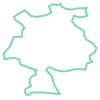

In [ ]:
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
polys = []
for rec, shape in canton04:
    poly = Polygon([(x,y) for x,y in shape.points])
    polys.append(poly)
union = cascaded_union(polys)
union.boundary

In [ ]:
wk = union.boundary.xy
xs, ys = wk[0].tolist(), wk[1].tolist()
x0, y0 = xs[0], ys[0]
locations = list(zip(xs, ys))

In [ ]:
import folium
map_osm = folium.Map(location=[y0, x0])
map_osm.add_child(folium.PolyLine(locations=locations, latlon=False, popup=str(d), color="#000000"))
folium_html_map(map_osm, width="50%")

<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x23b2e10aac8>

### Carte finale après fusion des contours

Cette fusion repose sur la fonctionnalité que nous venons de présenter à savoir la fusion de deux contours. Il faut aussi pouvoir associer un contour avec la solution gagnante. Cette solution a pour format ``{ circonscription : [ liste des bureaux ] }``. On rappelle les identifiants choisis :

* identifiant cironscription : **DDCCC#**, ``D`` pour code département, ``C`` pour code circonscription
* identifiant bureau de vote : **DDMMMAABBB#**, ``D`` pour code département, ``M`` pour code commune, ``C`` pour code commune, ``A`` pour code canton, le code du bureau est laissé à ``***`` si les données géolocalisées donne le même lieu pour plusieurs bureaux de vote.

Example avec le premier bureau :

In [ ]:
d = {k[0]:v for k,v in zip(r.fields[1:], records[0])}
d

{'BUREAU': '01001',
 'CANTON': 'CHATILLON-SUR-CHALARONNE',
 'CIRCO': '04',
 'CODE': '01001',
 'CODEARRT': '012',
 'CODECANT': '10',
 'CODEDEP': '01',
 'CODEREG': '82',
 'NOM': b"L'Abergement-Cl\xe9menciat"}

#### fonction 1 : créer un dictionnaire avec les contours des bureaux de vote

Les shapes sont dans un tableau indicés par des entiers. Il sera plus simple de les indicés par leur identidiant.

In [ ]:
shape_bureau = {}
for rec, shape in zip(records, shapes):
    d = {k[0]:v for k,v in zip(r.fields[1:], rec)}
    idbureau = shape_idbureau(d)
    shape_bureau[idbureau] = (d, shape)
    d["IDB"] = idbureau

In [ ]:
list(sorted(shape_bureau.items()))[2006:2008]

[('0506130013#',
  ({'BUREAU': '05061_013',
    'CANTON': 'Gap-Sud-Ouest',
    'CIRCO': '01',
    'CODE': '05061',
    'CODEARRT': '052',
    'CODECANT': '30',
    'CODEDEP': '05',
    'CODEREG': '93',
    'IDB': '0506130013#',
    'NOM': 'Gap'},
   <shapefile._Shape at 0x23ae0f2b518>)),
 ('0506220***#',
  ({'BUREAU': '05062',
    'CANTON': 'SAINT-FIRMIN',
    'CIRCO': '02',
    'CODE': '05062',
    'CODEARRT': '052',
    'CODECANT': '20',
    'CODEDEP': '05',
    'CODEREG': '93',
    'IDB': '0506220***#',
    'NOM': 'Le Glaizil'},
   <shapefile._Shape at 0x23ae130dcf8>))]

#### fonction 2 : transformer les idbureau dans la base initiale

Rappel : nous n'avons pas la localisation de tous les bureaux de vote. Certains ont été agrégés. On construit alors un nouveau identifiant ``idbureau2`` pour les bureaux de votes agrégés.

In [ ]:
def new_idbureau(r):
    if r in shape_bureau:
        return r
    else:
        return r[:-4] + "***#"
    
t1t2noz = t1t2noz.copy()
t1t2noz["idbureau2"] = t1t2noz["idbureau"].apply(lambda r: new_idbureau(r))

In [ ]:
t1t2noz[list(_ for _ in t1t2noz.columns if "candidat" not in _ and ("Code" in _ or "id" in _ or "N°" in _))].head(n=2)

,Code de la commune,Code département,N° de bureau de vote,N° de canton,N° de circonscription Lg,N° tour,idbureau,idcirc,idbureau2,idb=,idbgeo
47442,4,06,0101,1,7,1,0600401101#,06007#,0600401***#,False,True
47443,4,06,0101,1,7,1,0600401101#,06007#,0600401***#,False,True


On vérifie qu'on ne s'est pas trompé et que certains identifiants ont été retrouvés.

In [ ]:
t1t2noz["idb="] = t1t2noz["idbureau"] == t1t2noz["idbureau2"] 
t1t2noz["idbgeo"] = t1t2noz["idbureau2"].apply(lambda r: r in shape_bureau)
t1t2noz[["idb=", "idbgeo", "Nombre de voix du candidat"]].groupby(["idb=", "idbgeo"]).sum()

Nombre de voix du candidat
idb=  idbgeo                            
False False                      2866063
      True                      15351963
True  True                       5478231

Ce sont près de 2.8 millions de voix que nous n'arrivons pas à localiser. Nous ne pourrons pas les changer circonscriptions.

In [ ]:
t1t2noz[["idb=", "idbgeo", "idbureau2"]].groupby(["idb=", "idbgeo"]).count()

idbureau2
idb=  idbgeo           
False False       13748
      True       132620
True  True        26932

13748 lignes contiennent un identifiant du bureau de vote non localisé. Regardons les premiers.

In [ ]:
t1t2noz[~t1t2noz["idb="] & ~t1t2noz["idbgeo"]].head(n=2)

,Code de la commune,Code département,Code nuance du candidat,Exprimés,Inscrits,Nom de la commune,Nom du candidat,Nombre de voix du candidat,N° de bureau de vote,N° de canton,...,N° de dépôt du candidat,N° tour,Prénom du candidat,Votants,elu,idbureau,idcirc,idbureau2,idb=,idbgeo
47658,4,06,EXG,327,598,Antibes,PETARD,4,0201,47,...,8,1,Christian,334,True,0600447201#,06007#,0600447***#,False,False
47659,4,06,FN,327,598,Antibes,VIOT,68,0201,47,...,24,1,Mathilde,334,True,0600447201#,06007#,0600447***#,False,False


In [ ]:
list(set((t1t2noz[~t1t2noz["idb="] & ~t1t2noz["idbgeo"]])["Nom de la commune"]))[:5]

['Romorantin-Lanthenay', 'Cholet', 'Piedipartino', 'Rutali', 'Cozzano']

In [ ]:
t1t2noz[~t1t2noz["idb="] & ~t1t2noz["idbgeo"] & (t1t2noz["Nom de la commune"] == "Avelin")].head(n=10).T

,73887,73888
Code de la commune,34,34
Code département,59,59
Code nuance du candidat,SOC,UMP
Exprimés,255,255
Inscrits,438,438
Nom de la commune,Avelin,Avelin
Nom du candidat,DEFFONTAINE,LAZARO
Nombre de voix du candidat,116,139
N° de bureau de vote,0003,0003
N° de canton,48,48


In [ ]:
list((k,v[0]) for k, v in shape_bureau.items() if v[0]["NOM"] == "Avelin")

[('5903448002#',
  {'BUREAU': '59034_002',
   'CANTON': b'Pont-\xe0-Marcq',
   'CIRCO': '06',
   'CODE': '59034',
   'CODEARRT': '595',
   'CODECANT': '48',
   'CODEDEP': '59',
   'CODEREG': '31',
   'IDB': '5903448002#',
   'NOM': 'Avelin'}),
 ('5903448001#',
  {'BUREAU': '59034_001',
   'CANTON': b'Pont-\xe0-Marcq',
   'CIRCO': '06',
   'CODE': '59034',
   'CODEARRT': '595',
   'CODECANT': '48',
   'CODEDEP': '59',
   'CODEREG': '31',
   'IDB': '5903448001#',
   'NOM': 'Avelin'})]

Visiblement les bureaux de vote sont différents dans les deux bases pour la ville d'Avelin. Où est-ce ? D'après [l'internaute](http://www.linternaute.com/ville/avelin/ville-59034/bureaux-vote), il y a 3 bureaux de vote. On peut supposer que ces données viennent d'une mise à jour de la définition de bureaux de vote.

In [ ]:
locs = list((k,v[0],v[1]) for k, v in shape_bureau.items() if v[0]["NOM"] == "Avelin")
x0, y0 = locs[0][2].points[0]
map_osm = folium.Map(location=[y0, x0])
map_osm.add_child(folium.PolyLine(locations=locs[0][2].points, latlon=False, color="#FF0000"))
map_osm.add_child(folium.PolyLine(locations=locs[1][2].points, latlon=False, color="#0000FF"))
folium_html_map(map_osm, width="50%")

<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x23b326d54a8>

Regardons les bureaux localisés mais non répertoriés dans la base de vote.

4488 50521


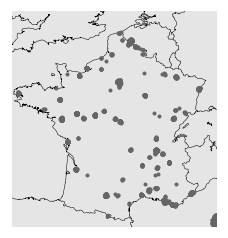

In [ ]:
ok_bureau = set(t1t2noz["idbureau2"])
fig, ax = plt.subplots()

x1, x2 = -5.0, 9.
y1, y2 = 42., 52.
m = Basemap(resolution='i',projection='merc', llcrnrlat=y1, urcrnrlat=y2, 
            llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2, ax=ax)
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)

lons = []
lats = []
for k, v in shape_bureau.items():
    if k in ok_bureau:
        # les bureaux sans voix
        continue
    x1, y1, x2, y2 = v[1].bbox
    x = (x1+x2) / 2
    y = (y1+y2) / 2
    lons.append(x)
    lats.append(y)
    
data = [m(x, y) for x,y in zip(lons, lats)]
xs = [_[0] for _ in data]
ys = [_[1] for _ in data]
print(len(xs), len(shape_bureau))
ax.plot(xs, ys, ".", color=(0.4, 0.4, 0.4))

**récupérer les 2.8 M de voix non localisées**

Pour les récupérer, nous allons agréger les bureaux de vote de la même commune et cantons en supposant que les erreurs commises ne seront pas trop grandes. Cette fois-ci c'est la variables ``shape_bureau`` qu'il faut modifier en fusionnant les bureaux pour lesquels nous n'avons pas de voix. Le tableau suivant résume les différents traitements que nous devons faire. L'étape 1 a déjà été faite. Il reste les étapes 2 et 3.

| étape | voix (t1t2noz)  | localisation (shape_bureau)  |
|--------------------|-----------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------|
| 0  | agrégation par bureau de vote | agrégation par bureau de vote et aussi par commune (``***``) |
| 1 | on corrige les identifiants de bureau non localisés en supposant qu'ils sont agrégés par commune (ajout de ``***``) | |
| 2  | | Les bureaux localisés mais sans voix associés ont disparus suite à un redécoupage. On les agrège au niveau de la commune (ajout de ``***``) |
| 3  | On agrège au niveau de la commune les bureaux agrégées localement par l'étape 2 (c'est-à-dire qu'on réapplique l'étape 1 |  |

On met à jour les identifiants des contours des bureaux :

In [ ]:
idbureau_voix = set(t1t2noz["idbureau2"])
shape_bureau_list = {}
for k, v in shape_bureau.items():
    if k not in idbureau_voix:
        # on enlève l'indice du bureau
        idb = k[:-4] + "***#"
    else:
        idb = k
    if idb not in shape_bureau_list:
        shape_bureau_list[idb] = []
    shape_bureau_list[idb].append(v)
len(shape_bureau), len(shape_bureau_list)

(50521, 46762)

On fusionne les contours. Les contours sont décrits plus en détail sur wikipédia : [shapefile](https://en.wikipedia.org/wiki/Shapefile#Shapefile_shape_format_.28.shp.29). Il reste quelques incohérences dans les informations associées à chaque forme. Le commentaire précise comment en trouver.

In [ ]:
import copy

def fusion_contours(idb, contours):
    d0 = contours[0][0] 
    d = d0.copy()
    d["BUREAU"] = d["BUREAU"].split("_")[0]
    sh = copy.deepcopy(contours[0][1])
    shapes = []
    for i, c in enumerate(contours):
        for k, v in c[0].items():
            # enlever CIRCO de la liste pour trouver des incohérences
            if k not in ("BUREAU", "CIRCO", "IDB", "NOM") and d[k] != v:
                raise Exception("Incohérence:\n{0}\n{1}\nk={2}\nidb={3}\ncheck={4}".format(d0, 
                                c[0], k, idb, shape_idbureau(c[0])))
            if c[1].shapeType != 5:
                raise Exception("Polygone attendu :\n{0}".format(c[1].__dict__))
            points = []
            last = None
            for x,y in c[1].points:
                pp = Point(x,y)
                if last is not None and last.almost_equals(p):
                    continue
                points.append((x,y))
            pol = Polygon(points)
            # simplifie le polygone
            pol = pol.simplify(tolerance=1e-5)
            # lire http://stackoverflow.com/questions/13062334/polygon-intersection-error-python-shapely
            # corrige les polygones qui se croisent
            pol = pol.buffer(0)
            shapes.append(pol)

    return cascaded_union(shapes)

new_shape_bureau = {}
for k, v in shape_bureau_list.items():
    if len(new_shape_bureau) % 1000 == 0:
        print(k, len(v), len(new_shape_bureau), "/", len(shape_bureau_list))
    if len(v) == 1:
        new_shape_bureau[k] = v[0]
    else:
        # fusion
        new_shape_bureau[k] = fusion_contours(k, v)   

3151137***# 1 0 / 46762
5937870014# 1 1000 / 46762
9207840012# 1 2000 / 46762
5215102***# 1 3000 / 46762
1407935***# 1 4000 / 46762
6614713***# 1 5000 / 46762
8034905***# 1 6000 / 46762
5553027***# 1 7000 / 46762
4403507005# 1 8000 / 46762
8801704***# 1 9000 / 46762
7411133***# 1 10000 / 46762
2839021***# 1 11000 / 46762
5924964009# 1 12000 / 46762
0255507***# 1 13000 / 46762
1614517***# 1 14000 / 46762
4601912***# 1 15000 / 46762
0908007***# 1 16000 / 46762
4721729***# 1 17000 / 46762
1005819***# 1 18000 / 46762
1006518***# 1 19000 / 46762
2526819***# 1 20000 / 46762
6287410***# 1 21000 / 46762
5730102***# 1 22000 / 46762
5430318***# 1 23000 / 46762
5935074009# 1 24000 / 46762
9300503034# 1 25000 / 46762
2833712***# 1 26000 / 46762
4221836064# 1 27000 / 46762
4522117***# 1 28000 / 46762
3246324***# 1 29000 / 46762
8312940011# 1 30000 / 46762
0602120***# 1 31000 / 46762
6058302***# 1 32000 / 46762
8078241***# 1 33000 / 46762
5549226***# 1 34000 / 46762
6928425***# 1 35000 / 46762
80419

Dernière étape : on corrige à nouveau les identifiants dans la base des votes

In [ ]:
def new_idbureau2(r):
    if r in new_shape_bureau:
        return r
    else:
        return r[:-4] + "***#"

t1t2noz = t1t2noz.copy()
t1t2noz["idbureau3"] = t1t2noz["idbureau2"].apply(lambda r: new_idbureau2(r))

In [ ]:
t1t2noz["idb2="] = t1t2noz["idbureau2"] == t1t2noz["idbureau3"] 
t1t2noz["idbgeo2"] = t1t2noz["idbureau3"].apply(lambda r: r in new_shape_bureau)
t1t2noz[["idb2=", "idbgeo2", "Nombre de voix du candidat"]].groupby(["idb2=", "idbgeo2"]).sum()

Nombre de voix du candidat
idb2= idbgeo2                            
True  False                       1490020
      True                       22206237

On n'a pas changé grand-chose côté base de vote mais le matching avec la base de localisation a été accru.

In [ ]:
t1t2noz[["idb=", "idbgeo", "Nombre de voix du candidat"]].groupby(["idb=", "idbgeo"]).sum()

Nombre de voix du candidat
idb=  idbgeo                            
False False                      2866063
      True                      15351963
True  True                       5478231

#### fonction 4 : fusionner tous les shapefiles (à venir)

In [ ]:
from itertools import groupby

def new_agg_bureau_shape_viz(thewinner, shape_bureau, data_vote, solution=None, 
                 col_circ="idcirc", col_place="idbureau", col_vote="Nombre de voix du candidat",
                 col_nuance="Code nuance du candidat", axes=None, figsize=(14,6), **kwargs):
    """
    Visualise la nuance gagnante dans chaque circonscription.
    
    @param     thewinner    parti qu'on souhaite influencer
    @param     shape_bureau dictionnaire ``{ idbureau : (information, shapefile)}``
    @param     axes         None ou deux systèmes d'axes
    @param     figsize      dimension du graphiques
    @param     kwargs       options additionnelles
    
    @param     data_vote    dataframe de type
    @param     solution     dictionnaire ``{ circonscription : liste de bureaux }``, 
                            si None considère la solution officielle
    @param     col_circ     colonne contenant la circonscription (si solution = None)
    @param     col_place    colonne contenant l'identifiant du bureaux de votes
    @param     col_vote     colonne contenant les votes
    @param     col_nuance   colonne contenant le parti ou la nuance
    @return                 matrice de resultat, une ligne par circoncription, une colonne par nuance/parti
    """
    # on transforme les dataframes en dictionnaires
    score = agg_circonscription(data_vote, solution=solution, 
                 col_circ=col_circ, col_place=col_place, col_vote=col_vote,
                 col_nuance=col_nuance)
    winner = score[["winner"]].to_dict("index")
    
    # on récupère le mapping idbureau --> idcirc
    if solution is None:
        # pas de solution, on récupère la configuration existante
        gr = data_vote[["idcirc", "idbureau", "Code département"]].groupby(["idcirc", "idbureau"], as_index=False).count()
        gr = gr[["idcirc", "idbureau"]].sort_values("idcirc")
        solution = {}
        for k, g in groupby(gr.values, lambda d: d[0]):
            solution[k] = list(_[1] for _ in g)
    
    if axes is None:
        # on créé des axes si non définis
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
    # on dessine la distribution des circonscriptions
    count = score[["winner", "nbwinner"]].groupby(["winner"]).count()
    count.sort_values("nbwinner", ascending=False)
    count.plot(ax=axes[1], kind="bar", legend=False)
    axes[1].set_xlabel("parti/nuance")
    axes[1].set_ylabel("nombre de circonscriptions")

    # on calcule le nombre de places le parti considéré
    count = count.reset_index(drop=False)
    count["iswin"] = count["winner"] == thewinner
    ratio = count[["nbwinner", "iswin"]].groupby("iswin").sum().sort_index()
    nbcirc = ratio.ix[1,0]
    axes[1].set_title("{0}={1} circonccriptions".format(thewinner, nbcirc))
    
    # on s'occupe de la carte
    x1 = -5.0
    x2 = 9.
    y1 = 42.
    y2 = 52.    
    m = Basemap(resolution='i',projection='merc', 
                llcrnrlat=y1, urcrnrlat=y2, llcrnrlon=x1, urcrnrlon=x2, lat_ts=(x1+x2)/2,
                ax=axes[0])
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    def dedup(ps):
        res = []
        for p in ps:
            if p not in res:
                res.append(p)
        return res
    
    for idcirc, idbureau in solution.items():        
        shapes = [shape_bureau[idb][1].points for idb in idbureau if idb in shape_bureau]
        if len(shapes) == 0:
            raise Exception("problem with " + idcirc)
        shapes = [Polygon(dedup([(x,y) for x,y in shape])) for shape in shapes if len(shape) > 0]
        try:
            union = cascaded_union(shapes)
        except Exception as e:
            for i in range(1, len(shapes)):
                try:
                    un = cascaded_union(shapes[:i])
                except Exception as e:
                    print("i", i-1, len(shapes))
                    print(idbureau[i-1])
                    print(shapes[i-1])
                    raise e
        lons = [_[0] for _ in union]
        lats = [_[1] for _ in union]
        data = numpy.array(m(lons, lats)).T
        segs = [data,]
        lines = LineCollection(segs,antialiaseds=(1,))
        # pour changer les couleurs c'est ici, il faudra utiliser le champ records
        # pour les changer en fonction du nom du départements
        if circ in winner:
            win = winner[circ]["winner"]
            color = (0.5, 1.0, 0.5) if win == thewinner else (1.0, 0.5, 0.5)
        else:
            color = "black"            
        lines.set_facecolors(color)
        lines.set_edgecolors('k')
        lines.set_linewidth(0.1)
        axes[0].add_collection(lines)  
        
    red_patch = mpatches.Patch(color=(1.0, 0.5, 0.5), label='perdu')
    green_patch = mpatches.Patch(color=(0.5, 1.0, 0.5), label='gagné')
    axes[0].legend(handles=[red_patch, green_patch])        

    return axes
    
new_agg_bureau_shape_viz("SOC", shape_bureau, t1t2noz)

## Construction des bureaux sur les frontières